In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq"
data_S3 = sc.read_10x_h5(data_path + "/outs_S3/filtered_feature_bc_matrix.h5")
data_S2 = sc.read_10x_h5(data_path + "/outs_S2/filtered_feature_bc_matrix.h5")
data_S3.obs["Sample"] = "S3"
data_S2.obs["Sample"] = "S2"


### Aggregate probes through max-pooling

In [4]:
data_maxpool_S3 = up.prep_probe_BacSC_data(data_S3, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool_S3, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool_S3

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1652 × 5572
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
data_maxpool_S2 = up.prep_probe_BacSC_data(data_S2, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool_S2, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool_S2

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1326 × 5572
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:
data_all = ad.concat([data_S2, data_S3], axis=0, keys=["S2", "S3"], index_unique="_")
print(data_all)
data_maxpool = ad.concat([data_maxpool_S2, data_maxpool_S3], axis=0, keys=["S2", "S3"], index_unique="_")
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(data_maxpool)

AnnData object with n_obs × n_vars = 2978 × 21982
    obs: 'Sample'
AnnData object with n_obs × n_vars = 2978 × 5572
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


In [7]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.941
Zero inflation of aggregated data: 0.842


## Attach transcription units

In [8]:
tu = pd.read_csv("../../data/MOBA_scRNAseq/PAO1 gene ID and TU.csv")
tu

PAO1_ID  TU_ID Regulation - transcription units of gene
0     PA0001      1             gyrB // recF // dnaN // dnaA
1     PA0002      1             gyrB // recF // dnaN // dnaA
2     PA0003      1             gyrB // recF // dnaN // dnaA
3     PA0004      1             gyrB // recF // dnaN // dnaA
4     PA0005      2                           PA0006 // lptA
...      ...    ...                                      ...
5692  PA5566   3750                                   PA5566
5693  PA5567   3751                                   PA5567
5694  PA5568   3752                                   PA5568
5695  PA5569   3753                             rpmH // rnpA
5696  PA5570   3753                             rpmH // rnpA

[5697 rows x 3 columns]

In [9]:
data_maxpool.var = pd.merge(data_maxpool.var, tu, left_index=True, right_on="PAO1_ID")
data_maxpool.var.index = data_maxpool.var["PAO1_ID"]
data_maxpool.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
PAO1_ID                                                      
PA0001                1421     1.063465           0.724387   
PA0002                1095     0.799530           0.587525   
PA0003                1673     1.539624           0.932016   
PA0004                 933     0.612156           0.477572   
PA0005                 409     0.218267           0.197430   
...                    ...          ...                ...   
PA5566                  40     0.016118           0.015990   
PA5567                 430     0.231363           0.208122   
PA5568                1379     1.023842           0.704997   
PA5569                2713     7.563801           2.147544   
PA5570                 909     0.903962           0.643937   

         pct_dropout_by_counts  total_counts  log1p_total_counts PAO1_ID  \
PAO1_ID                                                                    
PA0001               52.283412        3167.0            8.060856  PA0001   
PA0002               63.230356        2381.0            7.775696  PA0002   
PA0003               43.821357        4585.0            8.430763  PA0003   
PA0004               68.670248        1823.0            7.508787  PA0004   
PA0005               86.265950         650.0            6.478510  PA0005   
...                        ...           ...                 ...     ...   
PA5566               98.656817          48.0            3.891820  PA5566   
PA5567               85.560779         689.0            6.536692  PA5567   
PA5568               53.693754        3049.0            8.022897  PA5568   
PA5569                8.898590       22525.0           10.022425  PA5569   
PA5570               69.476158        2692.0            7.898411  PA5570   

         TU_ID Regulation - transcription units of gene  
PAO1_ID                                                  
PA0001       1             gyrB // recF // dnaN // dnaA  
PA0002       1             gyrB // recF // dnaN // dnaA  
PA0003       1             gyrB // recF // dnaN // dnaA  
PA0004       1             gyrB // recF // dnaN // dnaA  
PA0005       2                           PA0006 // lptA  
...        ...                                      ...  
PA5566    3750                                   PA5566  
PA5567    3751                                   PA5567  
PA5568    3752                                   PA5568  
PA5569    3753                             rpmH // rnpA  
PA5570    3753                             rpmH // rnpA  

[5572 rows x 9 columns]

### Filter cells

--> filter based on mean absolute standard deviation

In [10]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    2840
True      138
Name: count, dtype: int64
Total number of cells: 2978
Number of cells after filtering: 2840


AnnData object with n_obs × n_vars = 2840 × 5557
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells'

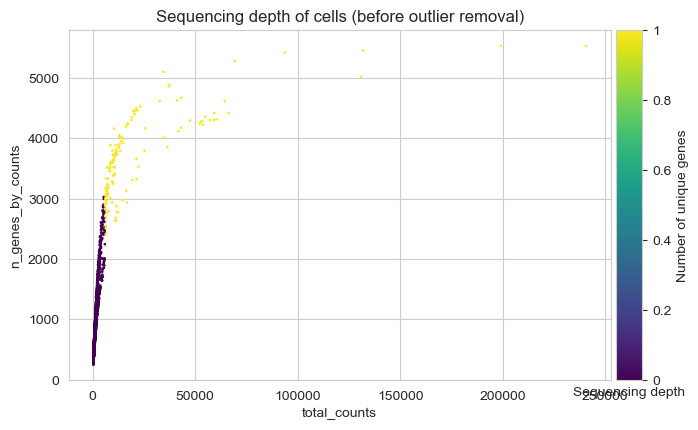

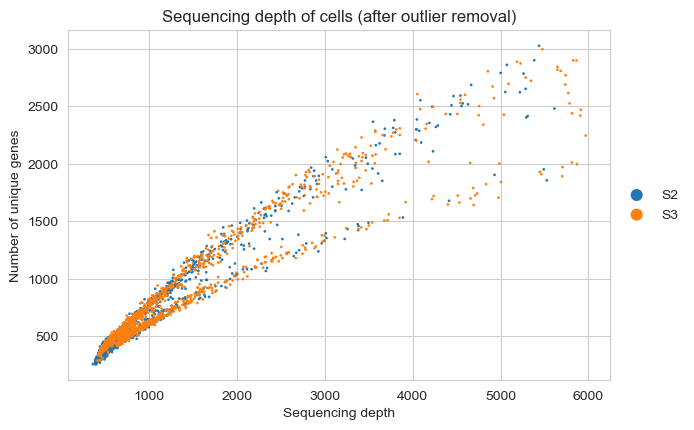

In [11]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="Sample")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [12]:
data_gene.layers["counts"] = data_gene.X.copy()

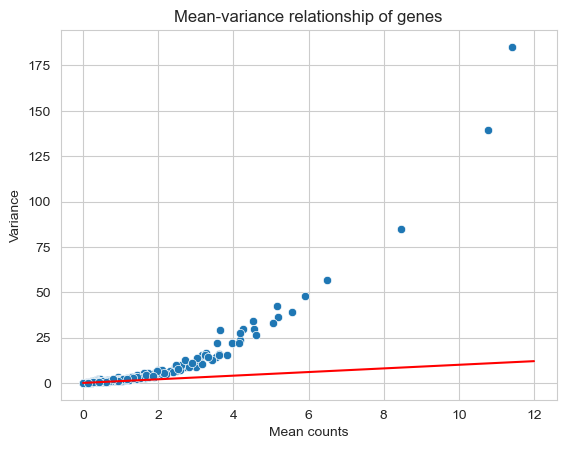

In [13]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [14]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts")

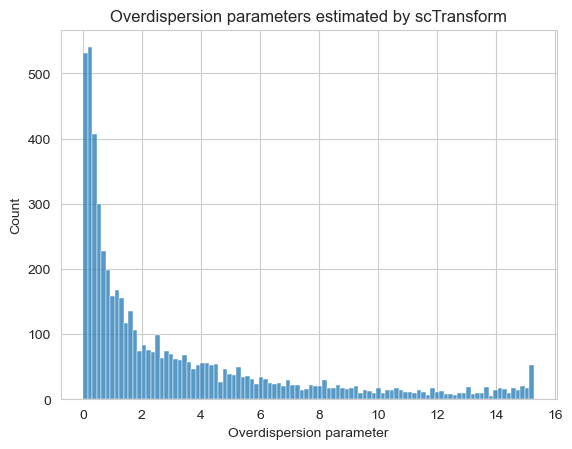

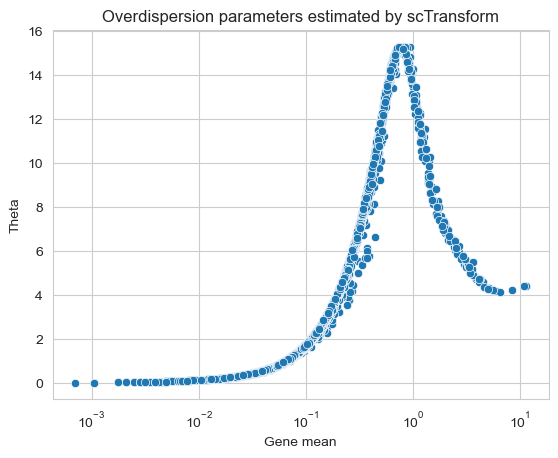

In [15]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [16]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [17]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

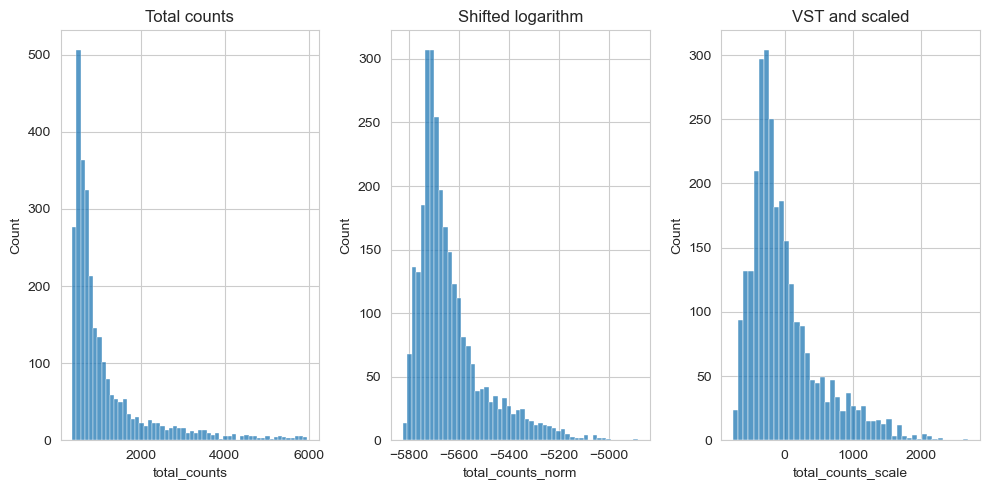

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [19]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 2840 × 5547
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'mean', 'std'
    layers: 'counts'


In [20]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

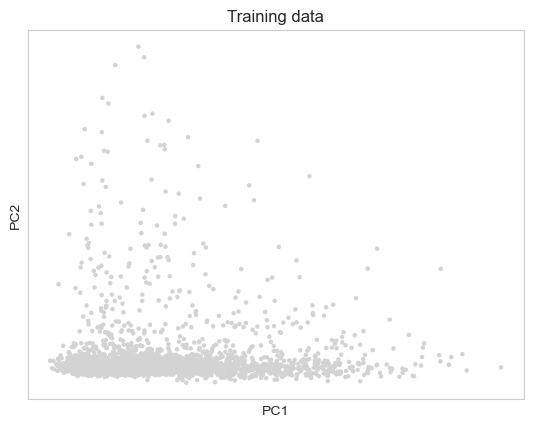

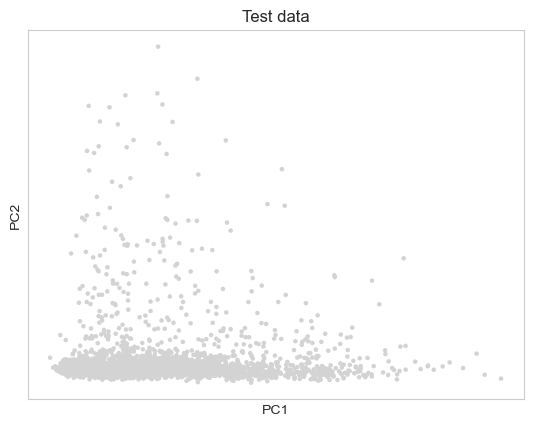

In [21]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [22]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:4


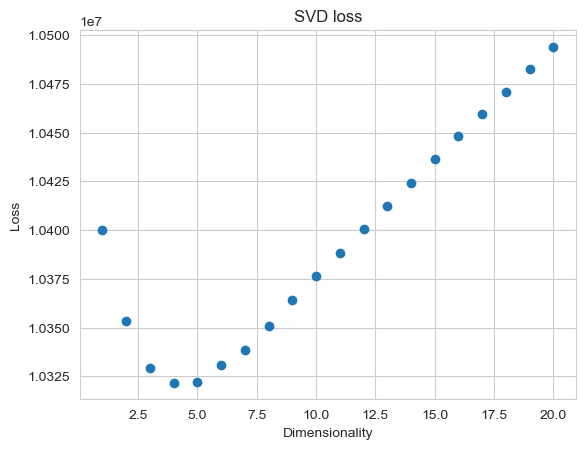

In [23]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

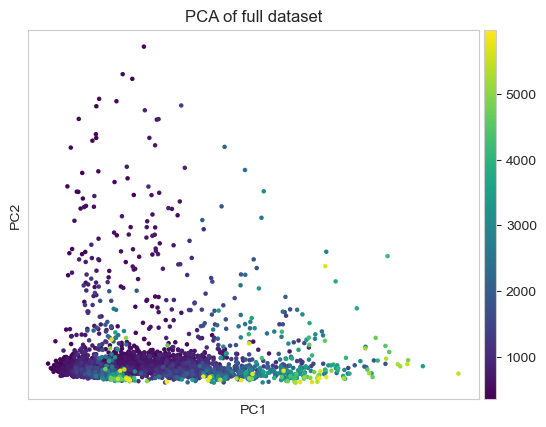

In [24]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

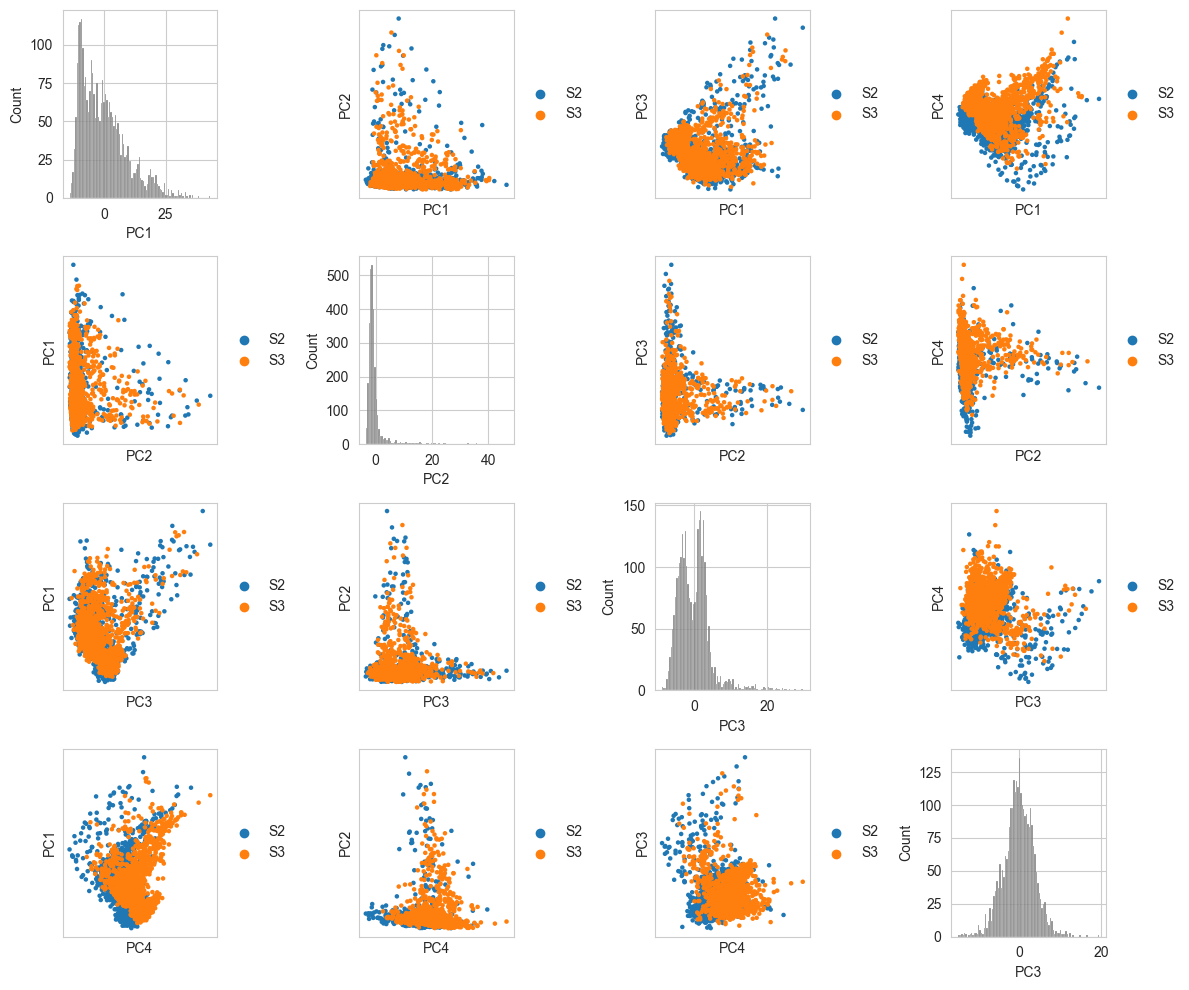

In [12]:
pca_df = pd.DataFrame(data_gene.obsm["X_pca"], index=data_gene.obs_names)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))
# cbar_ax = fig.add_axes([1.03, .3, .03, .5])

sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(0,1), ax=ax[0, 1], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(1, 0), ax=ax[1,0], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(1,2), ax=ax[1,2], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(2,1), ax=ax[2,1], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(0,2), ax=ax[0,2], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(2,0), ax=ax[2,0], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(0,3), ax=ax[0,3], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(1,3), ax=ax[1,3], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(2,3), ax=ax[2,3], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(3,0), ax=ax[3,0], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(3,1), ax=ax[3,1], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="Sample", cmap="tab10", dimensions=(3,2), ax=ax[3,2], title="", show=False, colorbar_loc=None)

sns.histplot(pca_df, x=0, ax=ax[0,0], color="dimgrey", bins=100)
ax[0,0].set(xlabel="PC1")
sns.histplot(pca_df, x=1, ax=ax[1,1], color="dimgrey", bins=100)
ax[1,1].set(xlabel="PC2")
sns.histplot(pca_df, x=2, ax=ax[2,2], color="dimgrey", bins=100)
ax[2,2].set(xlabel="PC3")
sns.histplot(pca_df, x=3, ax=ax[3,3], color="dimgrey", bins=100)
ax[3,3].set(xlabel="PC3")

# cmap = mpl.colormaps['viridis']
# norm = mpl.colors.Normalize(np.min(data_gene.obs["total_counts"]), np.max(data_gene.obs["total_counts"]))  # or vmin, vmax
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm, cmap), cbar_ax)
# cbar.set_label('Sequencing depth')

plt.tight_layout()

plt.show()

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [25]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=5678, embedding_method="UMAP", similarity_percent=0.5, save_path="S2S3_combined_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 70
Optimal min_dist: 0.3


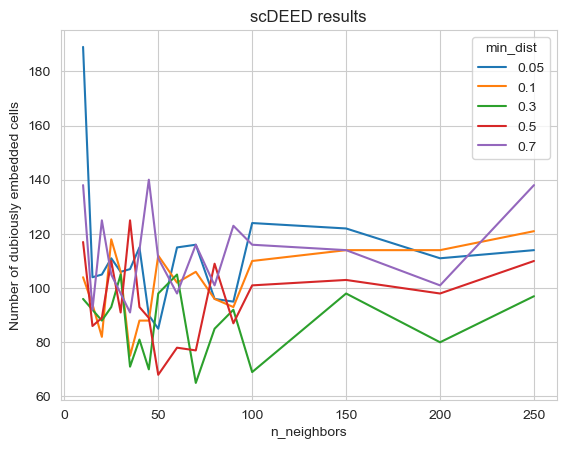

In [26]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [28]:
k_opt = 4
n_neighbors_opt = 70
min_dist_opt = 0.3

In [29]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


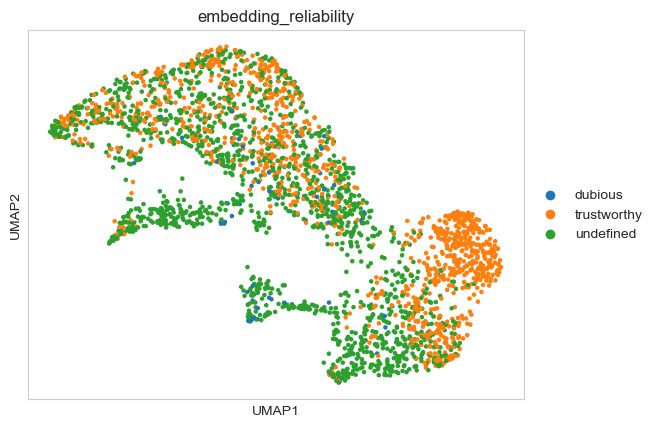

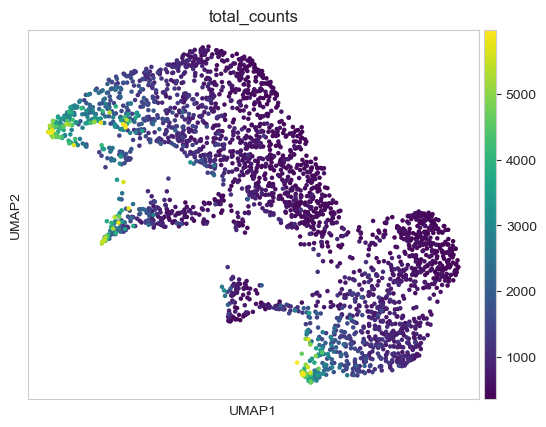

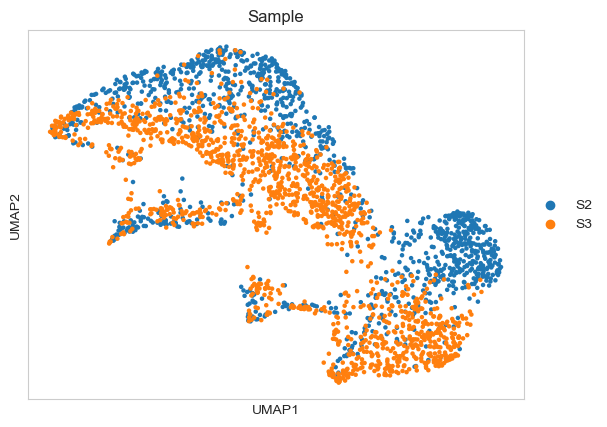

In [31]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

sc.pl.umap(data_gene, color="Sample")
plt.show()

In [32]:
data_gene.write(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [33]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

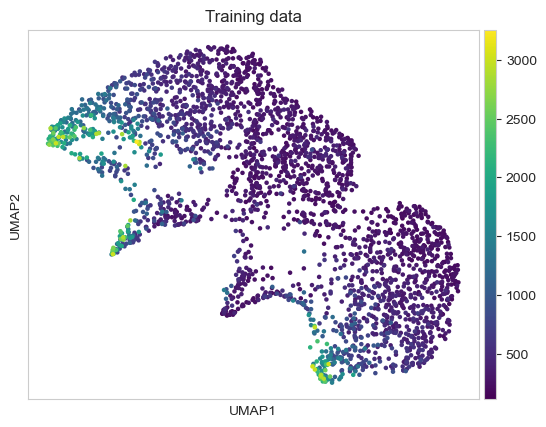

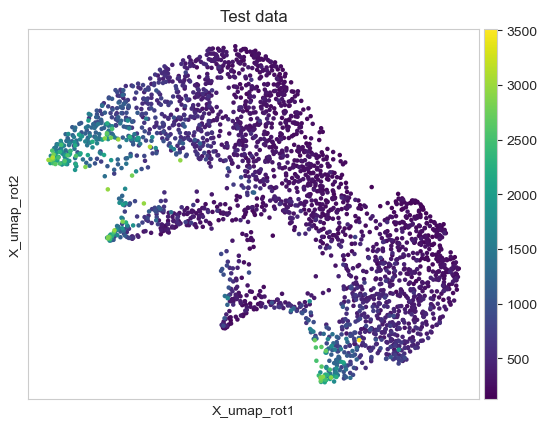

In [34]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [35]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

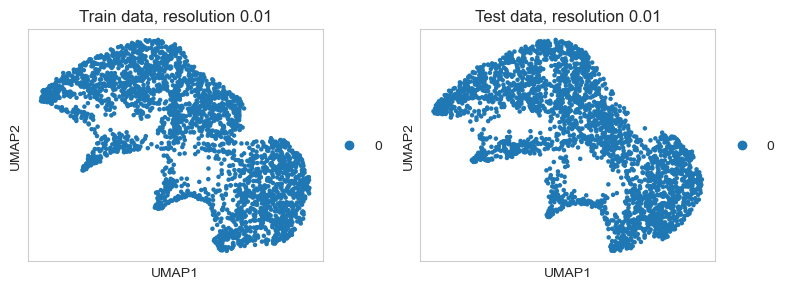

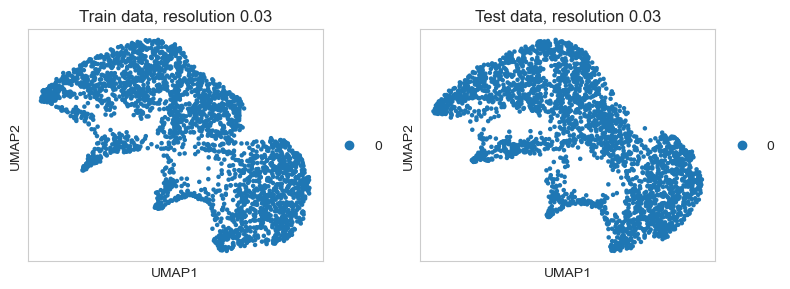

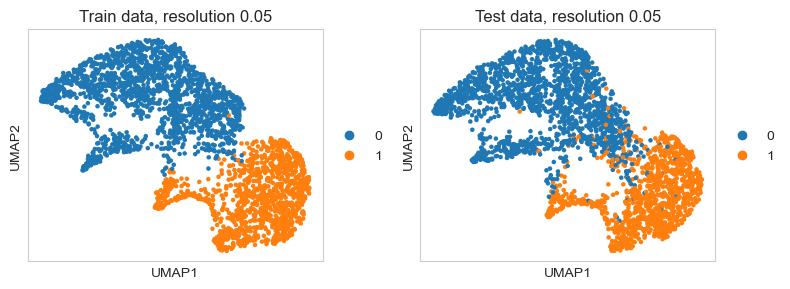

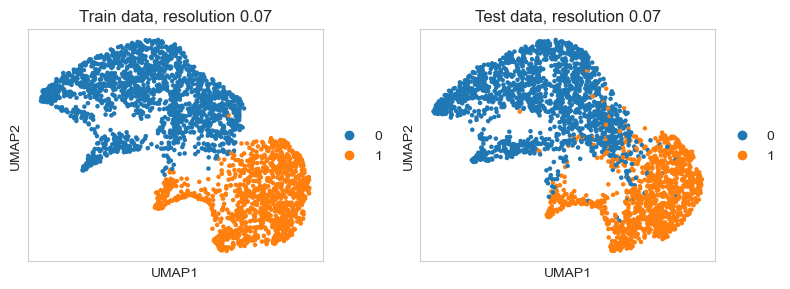

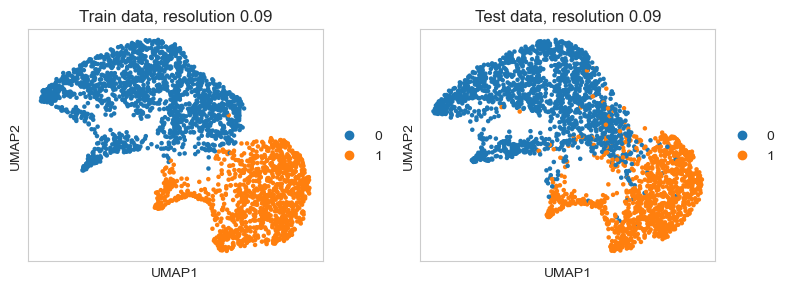

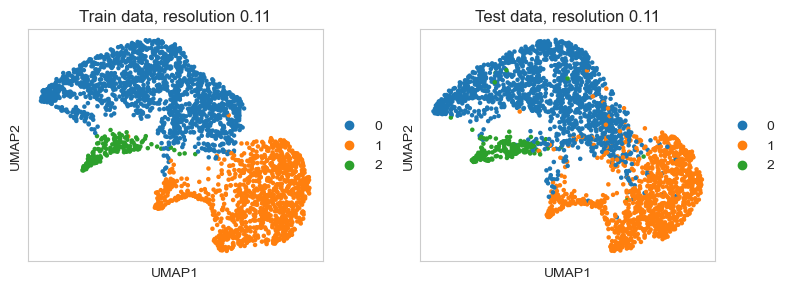

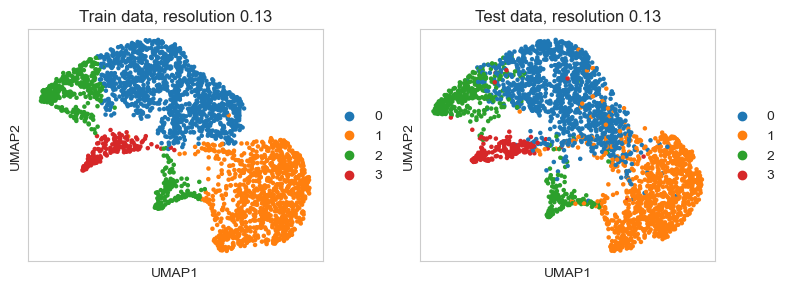

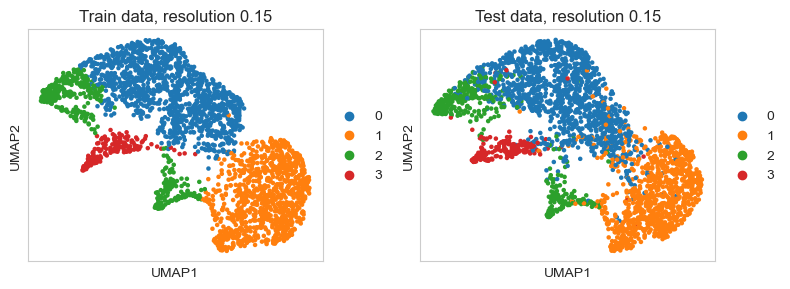

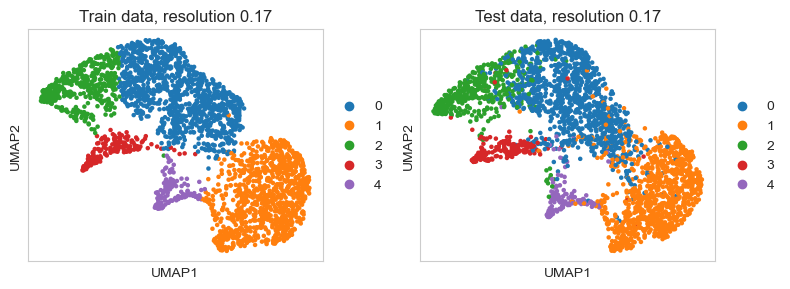

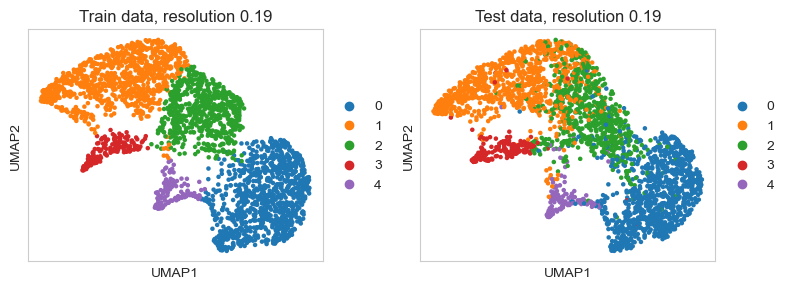

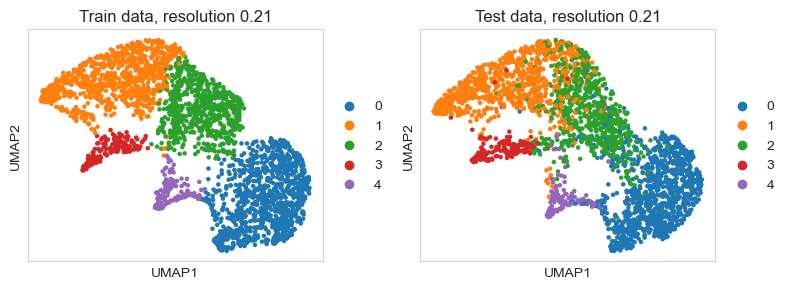

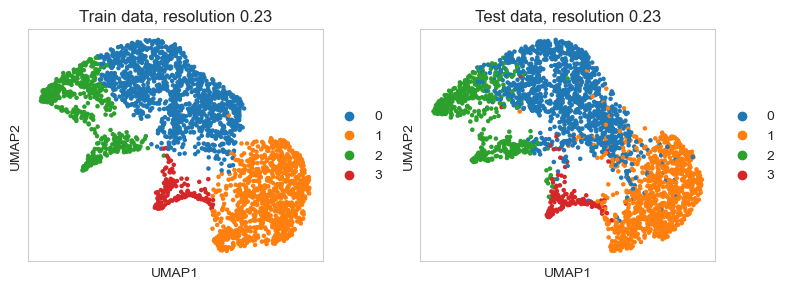

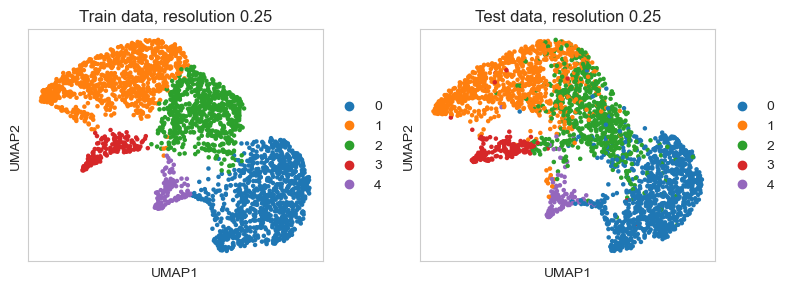

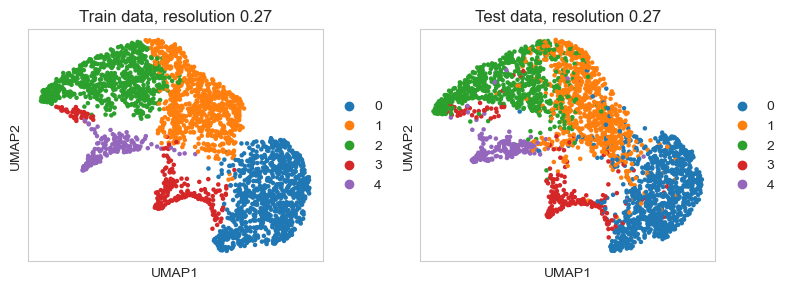

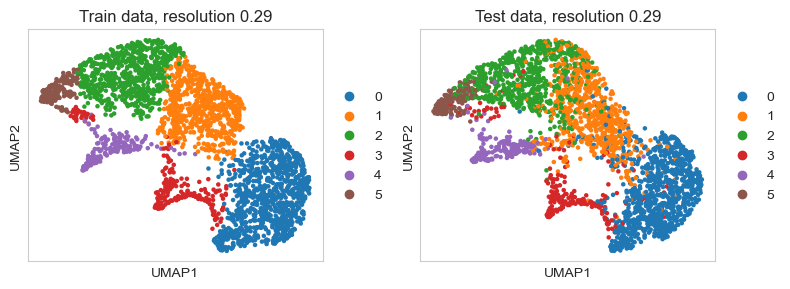

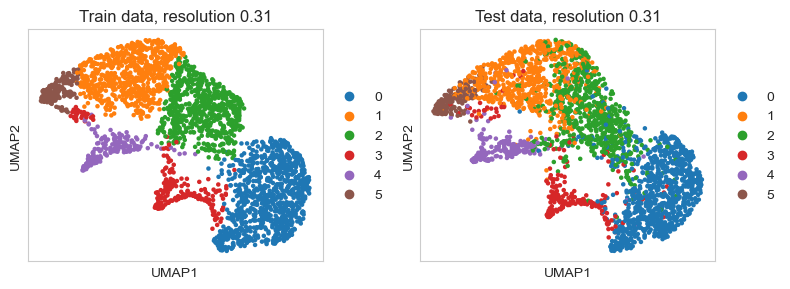

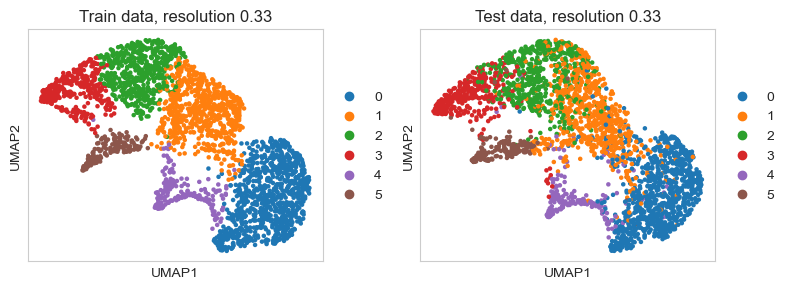

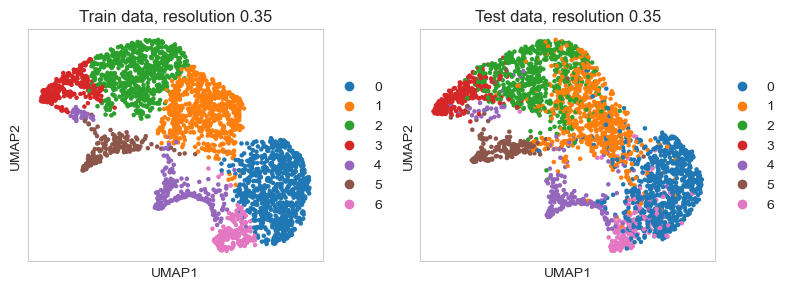

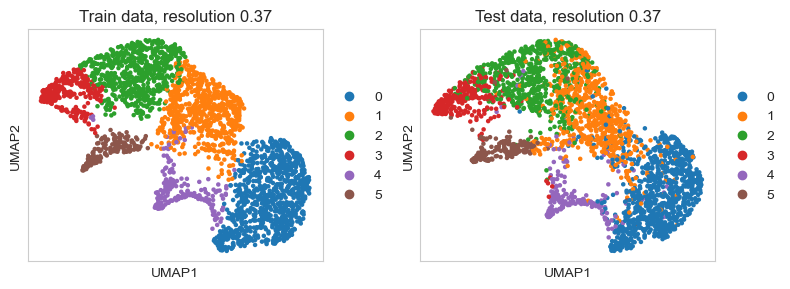

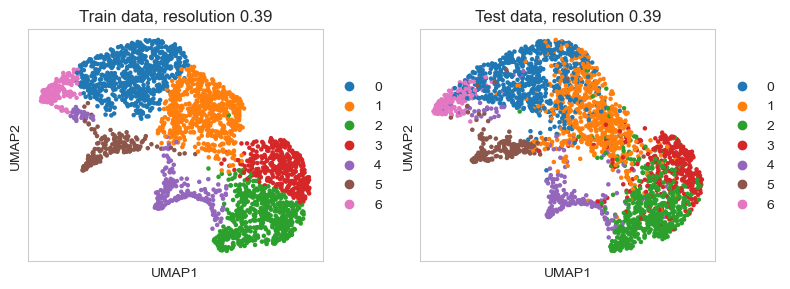

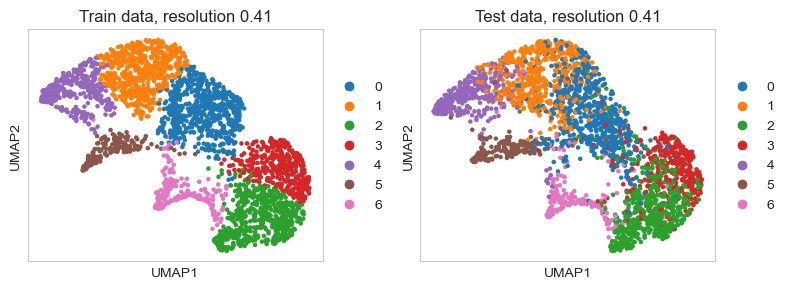

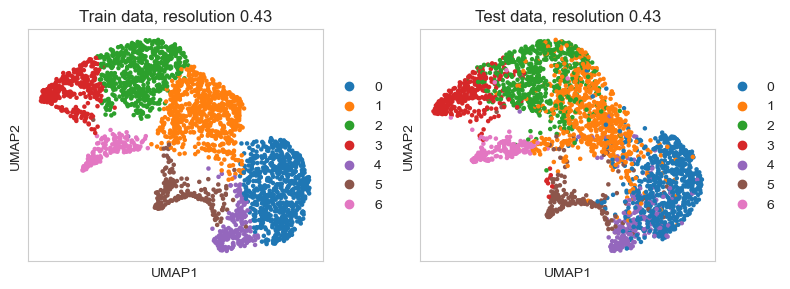

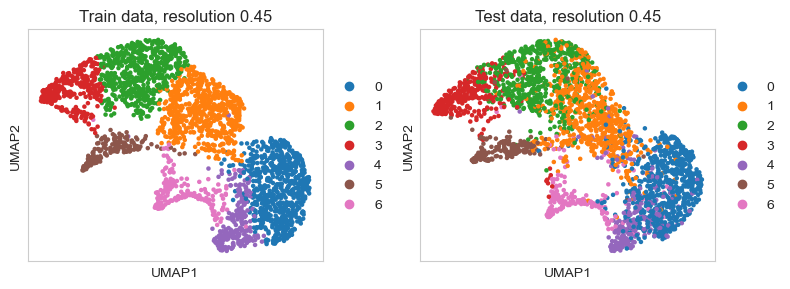

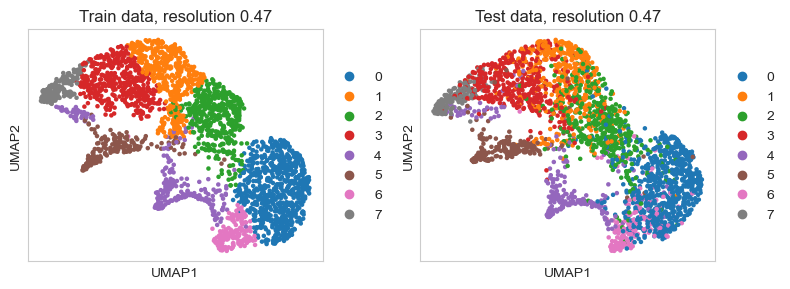

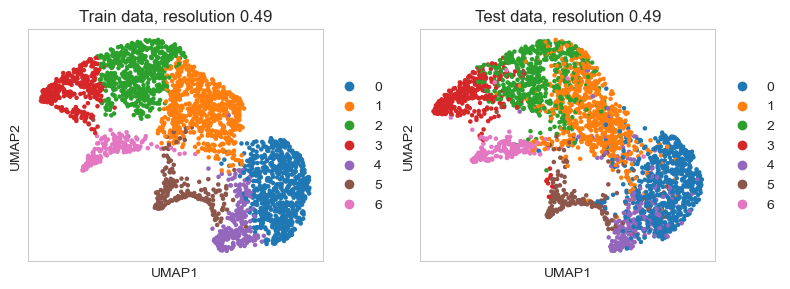

In [36]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [37]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.442 - Random: 0.235
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.431 - Random: 0.225
resolution: 0.09 - clusters: 2 - Train: 0.44 - Test: 0.42 - Random: 0.213
resolution: 0.11 - clusters: 3 - Train: 0.429 - Test: 0.406 - Random: 0.175
resolution: 0.13 - clusters: 4 - Train: 0.418 - Test: 0.388 - Random: 0.123
resolution: 0.15 - clusters: 4 - Train: 0.412 - Test: 0.381 - Random: 0.121
resolution: 0.17 - clusters: 5 - Train: 0.41 - Test: 0.372 - Random: 0.1
resolution: 0.19 - clusters: 5 - Train: 0.403 - Test: 0.35 - Random: 0.087
resolution: 0.21 - clusters: 5 - Train: 0.398 - Test: 0.347 - Random: 0.08
resolution: 0.23 - clusters: 4 - Train: 0.387 - Test: 0.355 - Random: 0.09
resolution: 0.25 - clusters: 5 - Train: 0.386 - Test: 0.332 - Random: 0.07
resolution: 0.27 - clusters

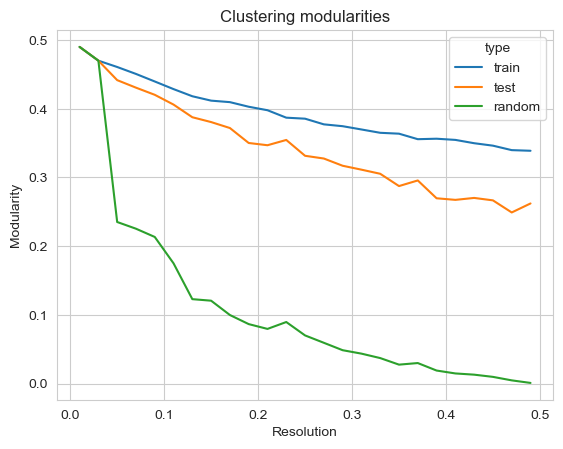

In [38]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

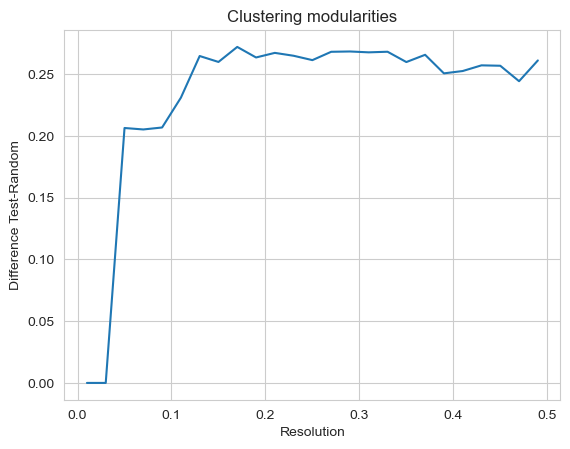

In [39]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [41]:
res_opt = 0.17

In [42]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

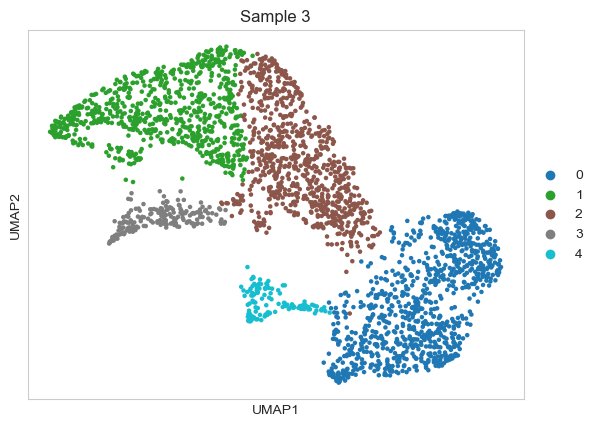

In [43]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [44]:
data_gene.write(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")

In [3]:
data_path = "../../data/MOBA_scRNAseq"
data_gene = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")

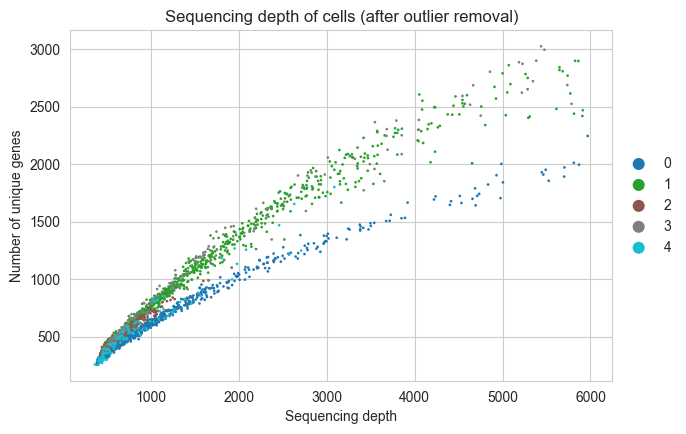

In [4]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

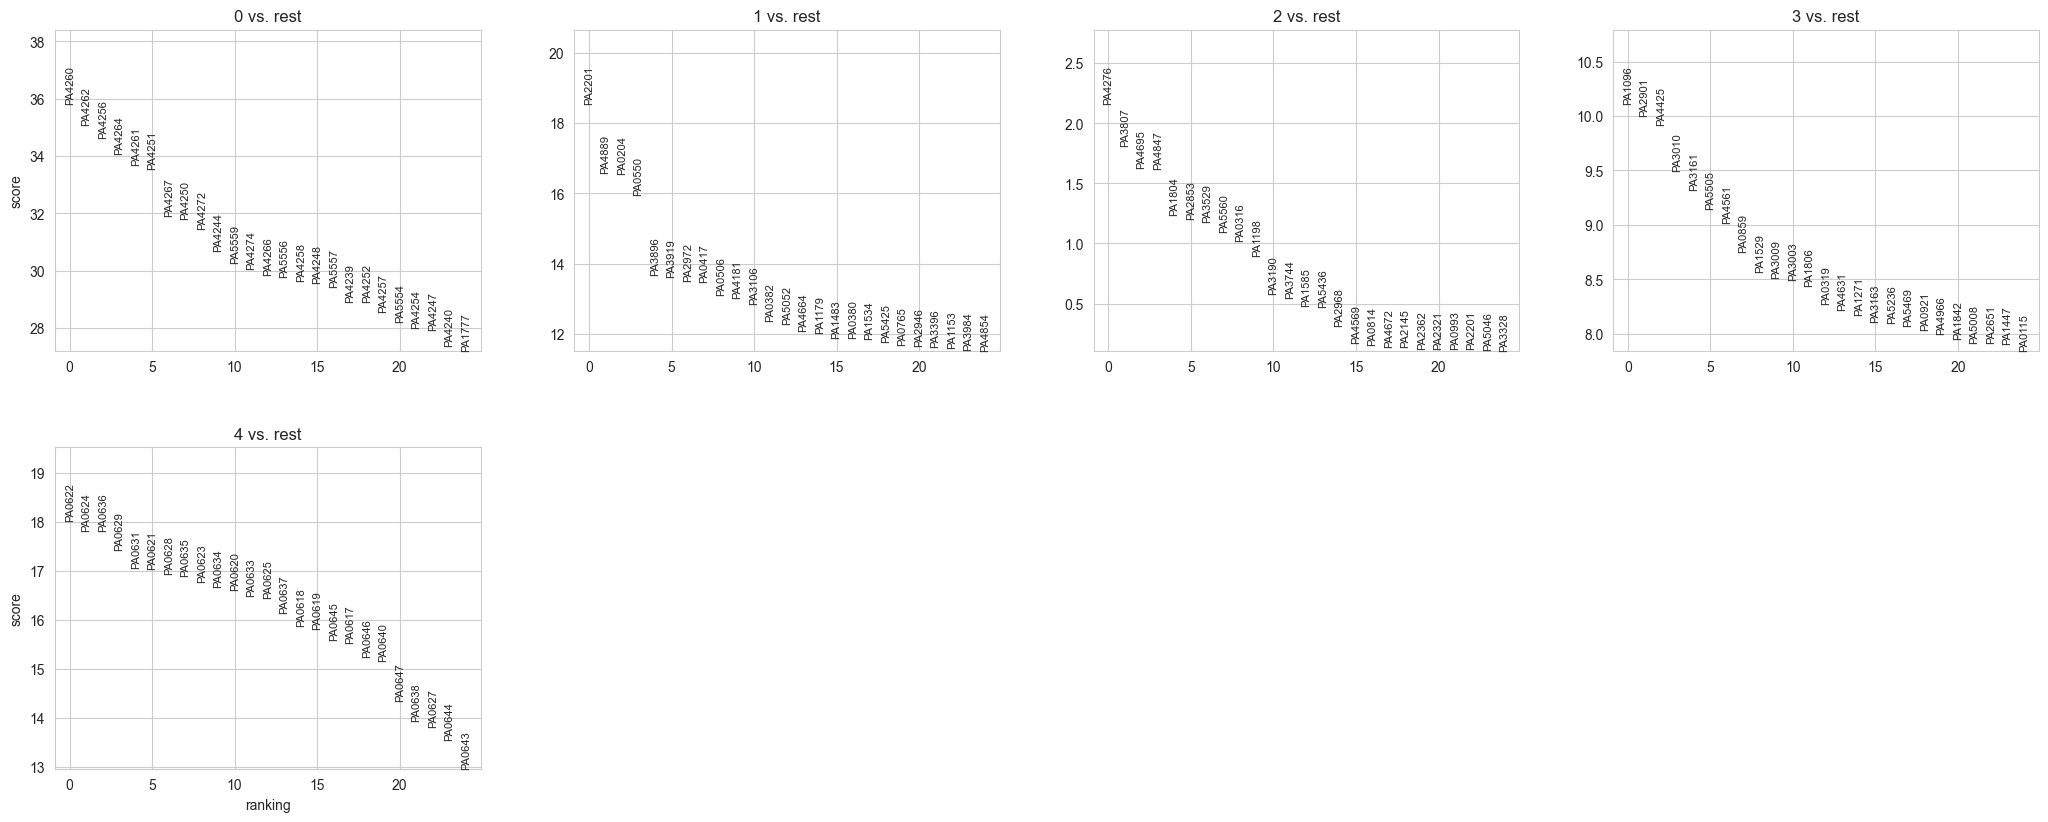

In [5]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

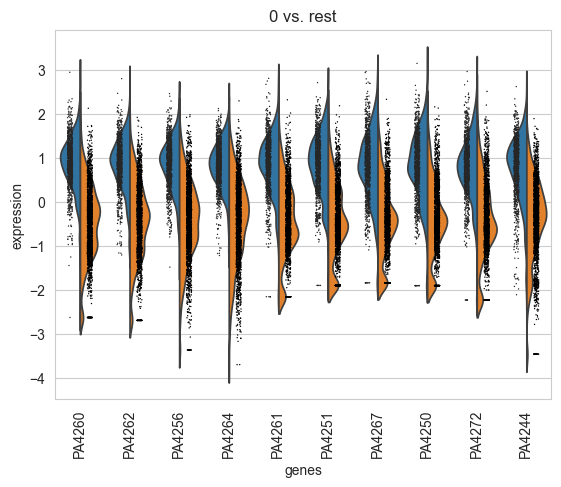

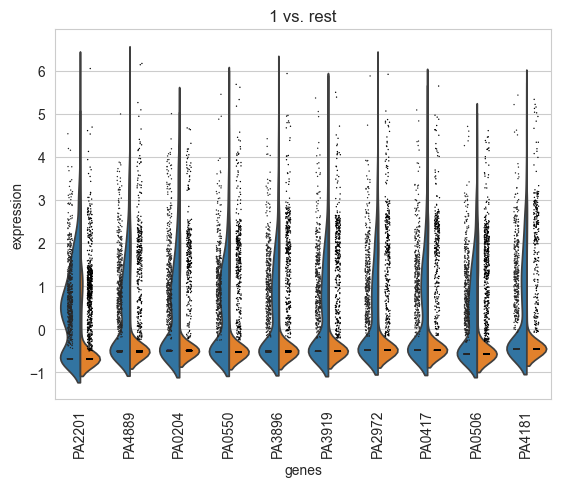

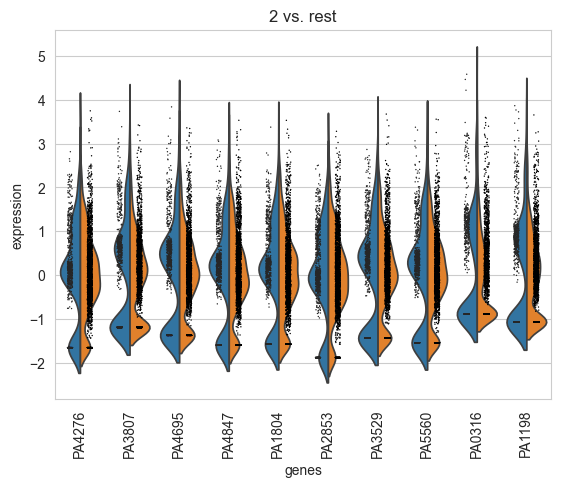

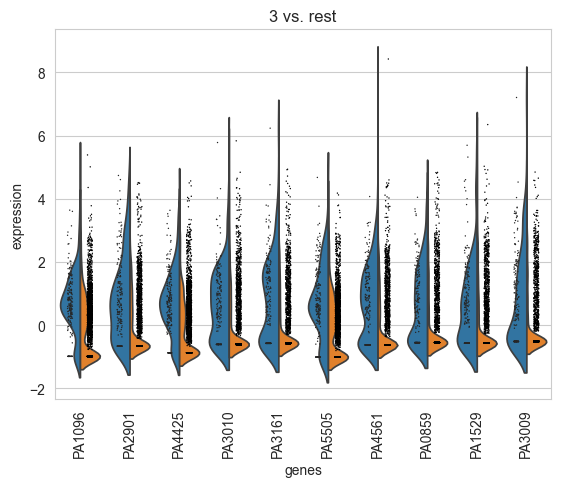

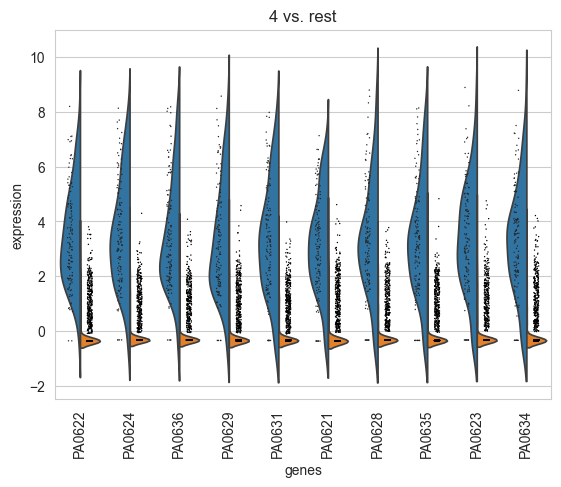

In [6]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

In [7]:
ct = pd.crosstab(data_gene.obs["Sample"], data_gene.obs["leiden_opt"])
print(ct)

print(np.sum(ct, axis=1))

ct_rel = ct.div(np.sum(ct, axis=1), axis=0)
print(ct_rel)

leiden_opt    0    1    2    3   4
Sample                            
S2          497  343  283  102  49
S3          477  435  490   89  75
Sample
S2    1274
S3    1566
dtype: int64
leiden_opt         0         1         2         3         4
Sample                                                      
S2          0.390110  0.269231  0.222135  0.080063  0.038462
S3          0.304598  0.277778  0.312899  0.056833  0.047893


In [13]:
import pertpy as pt

ImportError: cannot import name 'config' from 'jax.config' (/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/jax/config.py)

In [ ]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    data_gene,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden_opt",
    sample_identifier="Sample",
)

# plot boxplots
pt.pl.coda.boxplots(sccoda_data, modality_key="coda", feature_name="Sample", add_dots=True)
plt.show()

In [ ]:
pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="Sample")
plt.show()

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="Sample",
    reference_cell_type="automatic",
)


In [ ]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]

In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda", extended=True)